L'objectif de ce projet est d'observer s'il existe des "déserts sportifs", 
lieux en France où les infrastrcutures sportives manquent. 
La question sera alors d'essayer d'expliquer ces déserts sportifs, que ce soit par des raisons économiques ou politiques. 
Enfin, il s'agira de comparer la carte des déserts sportifs avec d'autres cartes connues, à l'instar des déserts médicaux.

In [72]:
#Installation des modules
!pip install py7zr geopandas openpyxl tqdm s3fs --quiet
!pip install PyYAML xlrd --quiet
!pip install cartiflette --quiet
!pip install contextily --quiet
!pip install folium --quiet
!pip install nb-clean --quiet
!pip install statsmodels --quiet

In [116]:
#Importation des modules
import numpy as np
import numpy.linalg as al
import matplotlib.pyplot as plt 
import pandas as pd
import geopandas as gpd
from cartiflette import carti_download
import requests
import io
import zipfile
import folium
from folium.plugins import HeatMap
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV


In [3]:
#Importation du jeu de données principal (localisation des équipements sportifs en France)

url = "https://data.sports.gouv.fr/api/explore/v2.1/catalog/datasets/equipements-sportifs/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
equipement = pd.read_csv(url, sep=";", low_memory=False)



#Importation d'un jeu de données csv sur des informations économiques et démographiques au niveau des communes

urlpop = "https://www.insee.fr/fr/statistiques/fichier/2521169/base_cc_comparateur_csv.zip"
response = requests.get(urlpop)

with zipfile.ZipFile(io.BytesIO(response.content)) as z:                 #io.BytesIO évite de télécharger le fichier
    with z.open("base_cc_comparateur.csv") as csvfile:                   #sur le disque dur
        df_communes = pd.read_csv(csvfile, sep=";", low_memory=False)


#Importation d'un jeu de données politiques au niveau des communes: résultats des législatives 2024 (2nd tour)

url2="https://www.data.gouv.fr/api/1/datasets/r/5a8088fd-8168-402a-9f40-c48daab88cd1"
legislatives2=pd.read_csv(url2, sep=";", low_memory=False)

In [4]:
#Visualisation de la base de données principale
equipement.head(3)

,Numéro de l'équipement sportif,Numéro de l'installation sportive,Date de l'enquête,Nom de l'installation sportive,SIRET Installation,Adresse,Code Postal,Commune nom,Commune INSEE,Type de particularité de l'installation,...,Accessibilité aux personnes en situation de handicap sensoriel aux tribunes,Accessibilité aux personnes en situation de handicap sensoriel aux vestiaires,Longitude,Latitude,Type de particularité de l'installation (brute),Activités,QPV,QPV à 200 mètres,Catégorie,gen_2024Fin_Labellisation
0,E001I010040004,I010040004,2025-03-31,Massif du Bas Bugey,NaN,NaN,1500,Ambérieu-en-Bugey,01004,NaN,...,False,False,5.35777,45.95805,NaN,Spéléologie,NaN,NaN,NaN,NaN
1,E001I010040006,I010040006,2025-03-31,COMPLEXE SPORTIF BELLIEVRE,NaN,Rue Alexandre Bérard,1500,Ambérieu-en-Bugey,01004,NaN,...,False,False,5.34839,45.97570,NaN,"Expression gymnique,Gymnastique Artistique,Gym...",NaN,NaN,structurant,NaN
2,E001I010040007,I010040007,2025-03-31,Gymnase St Exupéry,NaN,1 avenue de verdun,1500,Ambérieu-en-Bugey,01004,Complexe sportif,...,False,False,5.35613,45.96033,"[""Complexe sportif""]","Basket-Ball,Football / Football en salle (Futs...",NaN,NaN,proximité,NaN


In [5]:
#Visualisation de la base de données sur les informations économiques et démographiques
df_communes.head(3)

,CODGEO,P22_POP,P16_POP,SUPERF,NAIS1621,DECE1621,P22_MEN,NAISD24,DECESD24,P22_LOG,...,P22_CHOM1564,P22_ACT1564,ETTOT23,ETAZ23,ETBE23,ETFZ23,ETGU23,ETOQ23,ETTEF123,ETTEFP1023
0,01001,859.0,767.0,15.95,51.0,33.0,354.000000,8.0,4.0,379.000000,...,28.000000,431.000000,16.0,4.0,0.0,3.0,7.0,2.0,13.0,2.0
1,01002,273.0,243.0,9.15,14.0,11.0,121.000000,1.0,4.0,175.000000,...,2.000000,133.000000,4.0,1.0,0.0,0.0,2.0,1.0,3.0,0.0
2,01004,15554.0,14081.0,24.60,1325.0,808.0,7107.012476,175.0,118.0,7973.370708,...,1005.744641,7479.600207,599.0,1.0,31.0,61.0,420.0,86.0,435.0,132.0


In [6]:
#Visualisation de la base de données politique
legislatives2.head(3)

,Code département,Libellé département,Code commune,Libellé commune,Inscrits,Votants,% Votants,Abstentions,% Abstentions,Exprimés,...,Elu 17,Numéro de panneau 18,Nuance candidat 18,Nom candidat 18,Prénom candidat 18,Sexe candidat 18,Voix 18,% Voix/inscrits 18,% Voix/exprimés 18,Elu 18
0,01,Ain,01001,L'Abergement-Clémenciat,662,494,"74,62%",168,"25,38%",476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01,Ain,01002,L'Abergement-de-Varey,228,187,"82,02%",41,"17,98%",166,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01,Ain,01004,Ambérieu-en-Bugey,8745,5887,"67,32%",2858,"32,68%",5348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#On conserve les variables qui nous intéressent pour chaque jeu de données

#Pour le jeu de données principal
cols = ["Code Postal", "Commune nom", "Commune INSEE", "Département Code", "Densite Catégorie", "Type d'équipement sportif", 
        "Longitude", "Latitude"]
equipement = equipement[cols]

#Pour le jeu de données sur les informations économiques et démographiques
cols = ["CODGEO", "P22_POP", "P22_MEN","MED21", "TP6021", "P22_CHOM1564"]
df_communes = df_communes[cols]

#Pour le jeu de données politiques
cols = ["Code commune", "Libellé commune"]
cols += [(f"Nuance candidat {i}") for i in range(1, 5)]
cols += [(f"Elu {i}") for i in range(1, 5)]

legislatives2 = legislatives2[cols]

#Transformation de la variable élu en binaire pour tous les candidats
elu_cols = [f"Elu {i}" for i in range(1, 5)] 
for col in elu_cols:
    legislatives2[col] = legislatives2[col].notna().astype(int)  #Transforme les booléens en valeur 0 ou 1

In [8]:
#Visualisation nouvelle base de données principale
equipement.head(3)

,Code Postal,Commune nom,Commune INSEE,Département Code,Densite Catégorie,Type d'équipement sportif,Longitude,Latitude
0,1500,Ambérieu-en-Bugey,01004,1,Centres urbains intermédiaires,Espace de pratique spéléologique,5.35777,45.95805
1,1500,Ambérieu-en-Bugey,01004,1,Centres urbains intermédiaires,Salle de gymnastique sportive,5.34839,45.97570
2,1500,Ambérieu-en-Bugey,01004,1,Centres urbains intermédiaires,Multisports/City-stades,5.35613,45.96033


In [9]:
#Visualisation nouvelle base de données sur les informations économiques et démographiques
df_communes.head(3)

,CODGEO,P22_POP,P22_MEN,MED21,TP6021,P22_CHOM1564
0,01001,859.0,354.000000,25820,s,28.000000
1,01002,273.0,121.000000,24480,s,2.000000
2,01004,15554.0,7107.012476,21660,"17,0",1005.744641


In [10]:
#Visualisation nouvelle base de données politique
legislatives2.head(3)

,Code commune,Libellé commune,Nuance candidat 1,Nuance candidat 2,Nuance candidat 3,Nuance candidat 4,Elu 1,Elu 2,Elu 3,Elu 4
0,01001,L'Abergement-Clémenciat,ENS,RN,NaN,NaN,0,1,0,0
1,01002,L'Abergement-de-Varey,UG,UXD,NaN,NaN,0,1,0,0
2,01004,Ambérieu-en-Bugey,UG,UXD,NaN,NaN,0,1,0,0


In [11]:
#Dictionnaire des variables utilisées dans df_commune
pd.set_option("display.max_colwidth", None)

tab_communes = {
    "Variable": [
        "CODGEO", "P22_POP", "P22_MEN", "MED21", "TP6021", "P22_CHOM1564"
    ],
    "Description": [
        "Code INSEE de la commune",
        "Population en 2022",
        "Nombre de ménages en 2022",
        "Médiane du niveau de vie en 2021",
        "Taux de pauvreté en 2021",
        "Nombre de chômeurs de 15 à 64 ans en 2022"
    ]
}

dico_vars_communes = pd.DataFrame(tab_communes)
dico_vars_communes

,Variable,Description
0,CODGEO,Code INSEE de la commune
1,P22_POP,Population en 2022
2,P22_MEN,Nombre de ménages en 2022
3,MED21,Médiane du niveau de vie en 2021
4,TP6021,Taux de pauvreté en 2021
5,P22_CHOM1564,Nombre de chômeurs de 15 à 64 ans en 2022


In [12]:
#Dictionnaire des variables utilisées dans legislatives


tab_pol = {
    "Variable": ["Code commune", "Libellé commune", "Nuance candidat", "Elu"],
    "Description": [
        "Code INSEE de la commune",
        "Nom de la commune",
        "Parti politique du candidat",
        "Variable binaire égale à 1 si le candidat a été élu, 0 sinon"
    ]
}

dico_vars_pol = pd.DataFrame(tab_pol)
dico_vars_pol

,Variable,Description
0,Code commune,Code INSEE de la commune
1,Libellé commune,Nom de la commune
2,Nuance candidat,Parti politique du candidat
3,Elu,"Variable binaire égale à 1 si le candidat a été élu, 0 sinon"


In [13]:
#On souhaite créer une variable "Nuance politique du candidat élu" pour notre base de données finale

def get_nuance_elu(row):
    """
    Retourne la nuance du candidat élu pour la commune de la ligne "row"
    """
    if row['Elu 1']:
        return row['Nuance candidat 1']
    elif row['Elu 2']:
        return row['Nuance candidat 2']
    elif row['Elu 3']:
        return row['Nuance candidat 3']
    elif row['Elu 4']:
        return row['Nuance candidat 4']
    else:
        return np.nan

legislatives2['Nuance candidat élu'] = legislatives2.apply(get_nuance_elu, axis=1)

In [14]:
legislatives2.head(3)

,Code commune,Libellé commune,Nuance candidat 1,Nuance candidat 2,Nuance candidat 3,Nuance candidat 4,Elu 1,Elu 2,Elu 3,Elu 4,Nuance candidat élu
0,01001,L'Abergement-Clémenciat,ENS,RN,NaN,NaN,0,1,0,0,RN
1,01002,L'Abergement-de-Varey,UG,UXD,NaN,NaN,0,1,0,0,UXD
2,01004,Ambérieu-en-Bugey,UG,UXD,NaN,NaN,0,1,0,0,UXD


In [15]:
#On garde seulement la nuance du candidat élu, ce qui nous intéresse ici
cols = ["Code commune", "Nuance candidat élu"]
legislatives2 = legislatives2[cols]
legislatives2.head(3)

,Code commune,Nuance candidat élu
0,01001,RN
1,01002,UXD
2,01004,UXD


In [16]:
#On réunit tous les jeux de données pour obtenir notre jeu de données final

df_communes = df_communes.rename(columns={"CODGEO": "Commune INSEE"})
legislatives2 = legislatives2.rename(columns={"Code commune": "Commune INSEE"}) #On renomme les colonnes pour concaténer

df_final = (
    equipement
    .merge(df_communes, on="Commune INSEE", how="left")
    .merge(legislatives2, on="Commune INSEE", how="left")
)

df_final.head(12)

,Code Postal,Commune nom,Commune INSEE,Département Code,Densite Catégorie,Type d'équipement sportif,Longitude,Latitude,P22_POP,P22_MEN,MED21,TP6021,P22_CHOM1564,Nuance candidat élu
0,1500,Ambérieu-en-Bugey,01004,1,Centres urbains intermédiaires,Espace de pratique spéléologique,5.357770,45.958050,15554.0,7107.012476,21660,"17,0",1005.744641,UXD
1,1500,Ambérieu-en-Bugey,01004,1,Centres urbains intermédiaires,Salle de gymnastique sportive,5.348390,45.975700,15554.0,7107.012476,21660,"17,0",1005.744641,UXD
2,1500,Ambérieu-en-Bugey,01004,1,Centres urbains intermédiaires,Multisports/City-stades,5.356130,45.960330,15554.0,7107.012476,21660,"17,0",1005.744641,UXD
3,1500,Ambérieu-en-Bugey,01004,1,Centres urbains intermédiaires,Salle multisports (gymnase),5.348870,45.961530,15554.0,7107.012476,21660,"17,0",1005.744641,UXD
4,1330,Ambérieux-en-Dombes,01005,1,Bourgs ruraux,Terrain de boules,4.903600,45.990600,1917.0,814.669985,24610,s,63.323397,RN
5,1330,Ambérieux-en-Dombes,01005,1,Bourgs ruraux,Terrain de pétanque,4.904400,45.998900,1917.0,814.669985,24610,s,63.323397,RN
6,1330,Ambérieux-en-Dombes,01005,1,Bourgs ruraux,Terrain de football,4.901900,45.991700,1917.0,814.669985,24610,s,63.323397,RN
7,1500,Ambronay,01007,1,Rural à habitat dispersé,Espace de pratique spéléologique,5.361111,46.006389,2828.0,1207.205453,24860,s,105.671492,UXD
8,1500,Ambronay,01007,1,Rural à habitat dispersé,Terrain de football,5.348210,46.005740,2828.0,1207.205453,24860,s,105.671492,UXD
9,1500,Ambronay,01007,1,Rural à habitat dispersé,Salle d'échecs,5.360560,46.006670,2828.0,1207.205453,24860,s,105.671492,UXD


In [17]:
#En faisant le test avec ma commune d'origine, on se rend compte que des lignes sont parfois en double, 
#voire triple, on va donc supprimer ces doublons.

test=df_final[df_final["Commune nom"] == "Eschau"]
test



,Code Postal,Commune nom,Commune INSEE,Département Code,Densite Catégorie,Type d'équipement sportif,Longitude,Latitude,P22_POP,P22_MEN,MED21,TP6021,P22_CHOM1564,Nuance candidat élu
21331,67114,Eschau,67131,67,Ceintures urbaines,Court de tennis,7.72248,48.48419,5847.0,2442.0,27100,"8,0",186.0,ENS
39835,67114,Eschau,67131,67,Ceintures urbaines,Piste d'athlétisme isolée,7.71249,48.48587,5847.0,2442.0,27100,"8,0",186.0,ENS
68413,67114,Eschau,67131,67,Ceintures urbaines,Salles polyvalentes / des fêtes / non spécialisées,7.71452,48.48649,5847.0,2442.0,27100,"8,0",186.0,ENS
68414,67114,Eschau,67131,67,Ceintures urbaines,Terrain de pétanque,7.72177,48.48550,5847.0,2442.0,27100,"8,0",186.0,ENS
68415,67114,Eschau,67131,67,Ceintures urbaines,Manège,7.70778,48.47952,5847.0,2442.0,27100,"8,0",186.0,ENS
88759,67114,Eschau,67131,67,Ceintures urbaines,Terrain de handball,7.71249,48.48587,5847.0,2442.0,27100,"8,0",186.0,ENS
176827,67114,Eschau,67131,67,Ceintures urbaines,Court de tennis,7.72248,48.48419,5847.0,2442.0,27100,"8,0",186.0,ENS
176828,67114,Eschau,67131,67,Ceintures urbaines,Multisports/City-stades,7.72147,48.48480,5847.0,2442.0,27100,"8,0",186.0,ENS
176829,67114,Eschau,67131,67,Ceintures urbaines,Parcours de cross,7.70778,48.47952,5847.0,2442.0,27100,"8,0",186.0,ENS
185861,67114,Eschau,67131,67,Ceintures urbaines,Court de tennis,7.72331,48.48406,5847.0,2442.0,27100,"8,0",186.0,ENS


In [18]:
#Supression des lignes doublons
df_final = df_final.drop_duplicates()

In [19]:
#Maintenant, on va regarder le type des colonnes pour mettre les variables dans le format
#qui nous arrange

print(df_final.dtypes)

Code Postal                    int64
Commune nom                   object
Commune INSEE                 object
Département Code              object
Densite Catégorie             object
Type d'équipement sportif     object
Longitude                    float64
Latitude                     float64
P22_POP                      float64
P22_MEN                      float64
MED21                         object
TP6021                        object
P22_CHOM1564                 float64
Nuance candidat élu           object
dtype: object


In [20]:
#On va convertir les Code de départements en entier

#On fait le choix de Remplacer 2A et 2B par 96 et 97
df_final['Département Code'] = df_final['Département Code'].replace({'2A': '96', '2B': '97'})

#On convertit en entier, coerce nous permet de gérer les erreurs en cas de valeur manquante
df_final['Département Code'] = pd.to_numeric(df_final['Département Code'], errors='coerce').astype('Int64')

In [21]:
#Finalement, on ne conserve que les données sur la France métropolitaine, afin de faciliter les 
#représentations graphiques (cartes)

df_final = df_final[1 <= (df_final['Département Code'] <= 97)]

In [22]:
df_final['MED21'] = pd.to_numeric(df_final['MED21'], errors='coerce').astype('Int64')


On va maintenant passer à une représentation graphique des données


In [23]:
#On récupère le fond de carte de la france métropolitaine


#Téléchargement de toute la France avec les DROM
gdf = carti_download(
    values="France",
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

#Filtrer pour ne garder que la métropole (exclure les DROM)
departements_drom = ["971", "972", "973", "974", "975", "976"]
gdf = gdf[~gdf['INSEE_DEP'].isin(departements_drom)]

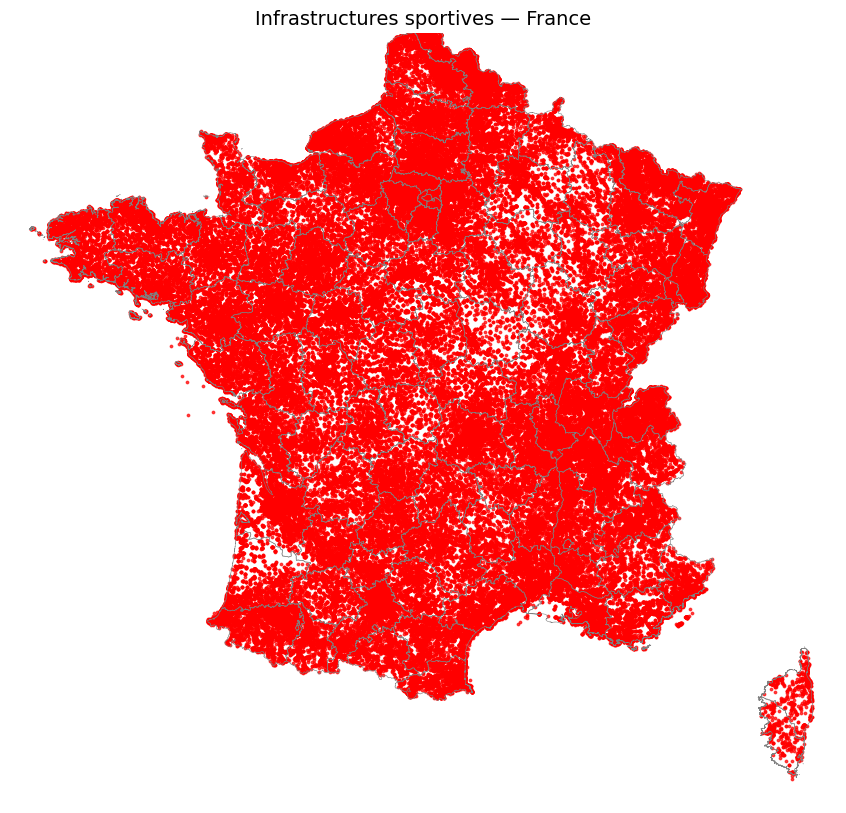

In [24]:
gdf_pts = gpd.GeoDataFrame(
    df_final,
    geometry=gpd.points_from_xy(df_final["Longitude"], df_final["Latitude"]),
    crs="EPSG:4326"
)


fig, ax = plt.subplots(figsize=(20, 10))
gdf.boundary.plot(ax=ax, linewidth=0.4, color="gray")
gdf_pts.plot(ax=ax, markersize=3, alpha=0.7, color="red")
ax.set_xlim(-5.5, 10) 
ax.set_ylim(41, 51)
ax.set_title("Infrastructures sportives — France", fontsize=14)
ax.set_axis_off()
plt.savefig('docs/premiere_carte.png', dpi=300, bbox_inches='tight')

On voit que le schéma de la "diagonale du vide" semble se reproduire avec les infrastructures sportives.
La densité des infrastructures sportives en Corse semble moins importante qu'en France métropolitaine.

In [25]:
#Carte de chaleur 


df = df_final.copy().dropna(subset=['Latitude', 'Longitude'])  #Supression des valeurs manquantes

#Création de la carte, centrée sur la France
calor = folium.Map(
    location=[46.5, 2.5],
    zoom_start=6,
    tiles='CartoDB positron'
)

#Récupération des données géographiques
heat_data = [[row['Latitude'], row['Longitude']] for idx, row in df.iterrows()]


#On complète la carte
HeatMap(
    heat_data,
    radius=15,           # Rayon de chaque point
    blur=20,             # Flou pour adoucir
    max_zoom=13,         # Zoom maximum
    gradient={            # Dégradé de couleurs personnalisé
        0.0: 'blue',
        0.3: 'lime',
        0.5: 'yellow',
        0.7: 'orange',
        1.0: 'red'
    }
).add_to(calor)
calor.save('docs/heatmap_toutes_infrastructures.html') #On sauvegarde la carte

In [62]:
def carte_interactive(df, info_couleur, titre_legende, info_survol, chemin_sauvegarde):
    """

    Affiche un graphique et un tableau côte à côte à partir d'un DataFrame à 2 colonnes
    
    Paramètre
    ----------
    df : DataFrame
        DataFrame contenant les informations à représenter sur la carte interactive
        
    info_couleur : str
        Nom de la variable du DataFrame selon laquelle on veut colorer la carte

    titre_legende : str
        Titre de la légende de couleurs

    info_survol : list
        Liste des variables (str) pour lesquelles on veut afficher les informations au survol de la souros

    chemin_sauvegarde : str
        Endroit où l'on veut sauvegarder la carte
    """

    #On copie le fond de carte pour ne pas le modifier directement
    gd = gdf.copy()
    
    
    #Fusion des données selon les codes de département
    gd = gd.merge(                 
    infra_par_dept, 
    left_on='INSEE_DEP', 
    right_on='Département Code', 
    how='left'
    )

    #Création de la carte, centrée sur la France
    m = folium.Map(
        location=[46.5, 2.5],
        zoom_start=6,
        tiles='CartoDB positron'
    )

    #On complète la carte
    folium.Choropleth(
        geo_data=gd,
        name='choropleth',
        data=df,
        columns=['Département Code', info_couleur],
        key_on='feature.properties.INSEE_DEP',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=titre_legende
    ).add_to(m)


    #Ajout des informations au survol de la souris
    folium.GeoJson(
        gd,
        style_function=lambda x: {'fillColor': 'transparent', 'color': 'transparent'},
        tooltip=folium.GeoJsonTooltip(
            fields=['INSEE_DEP'] + info_survol,
            localize=True
        )
    ).add_to(m)
    m.save(chemin_sauvegarde)

In [ ]:
def format_dept_code(code):
    """
    Ajouter un zéro devant les codes à 1 chiffre (1 → 01)
    """
    if code in ['2A', '2B']:
        return code
    if int(code) >= 10:
        return code
    else:
        return "0" + code

In [64]:
#On crée une carte qui compte le nombre d'infrastructures sportives par département

infra_par_dept = df_final.copy().groupby('Département Code').size().reset_index(name="Nombre d'infrastructures")

#On réadapte les codes de département pour correspondre au fond de carte
infra_par_dept['Département Code'] = infra_par_dept['Département Code'].astype(str)
infra_par_dept['Département Code'] = infra_par_dept['Département Code'].replace({
    '96': '2A',
    '97': '2B'
})


infra_par_dept['Département Code'] = infra_par_dept['Département Code'].apply(format_dept_code)
print("-" * 50)
print("Visualisation de la base de données infra_par_dept")
print("-" * 50)
print(infra_par_dept.head(4))

carte_interactive(infra_par_dept, "Nombre d'infrastructures", "Nombres d'infrastructures sportives",
                  ["Nombre d'infrastructures"], 'docs/carte_departements.html')

--------------------------------------------------
Visualisation de la base de données infra_par_dept
--------------------------------------------------
  Département Code  Nombre d'infrastructures
0               01                      3855
1               02                      3165
2               03                      2183
3               04                      1576


On observe sur cette carte que la Moselle et le Nord sont les départements comptant le plus grand nombre d’infrastructures sportives, tandis que les deux départements corses en disposent nettement moins.
Cependant, cette lecture doit être nuancée : la carte ne tient pas compte du nombre d’habitants ni du revenu médian de chaque département, deux facteurs essentiels pour interpréter correctement ces écarts.
Observons maintenant l'effet de la population sur cette carte.

In [65]:
#Estimation du nombre d'habitants par département avec les communes disponibles dans la base de données
pop_par_dept = df_final.copy()[['Département Code', 'Commune INSEE', 'P22_POP']].drop_duplicates(
    subset=['Commune INSEE']
).groupby('Département Code')['P22_POP'].sum().reset_index()


pop_par_dept['Département Code'] = pop_par_dept['Département Code'].astype(str)
pop_par_dept['Département Code'] = pop_par_dept['Département Code'].replace({
    '96': '2A',
    '97': '2B'
})

pop_par_dept.columns = ['Département Code', 'Population totale']
pop_par_dept['Département Code'] = pop_par_dept['Département Code'].apply(format_dept_code)

infra_par_dept = infra_par_dept.merge(pop_par_dept, on='Département Code', how='left')

infra_par_dept['Infrastructures pour 10000 habitants'] = (
    infra_par_dept["Nombre d'infrastructures"] / infra_par_dept['Population totale'] * 10000
).round(2) #Calcul du nombre d'infrastructures pour 10000 habitants

print("-" * 50)
print("Visualisation de la base de données infra_par_dept")
print("-" * 50)
print(infra_par_dept.head(4))


carte_interactive(infra_par_dept, 'Infrastructures pour 10000 habitants', 'Infrastructures sportives pour 10000 habitants', 
                  ["Nombre d'infrastructures", "Population totale", "Infrastructures pour 10000 habitants"],
                  'docs/carte_infra_par_habitant.html')

--------------------------------------------------
Visualisation de la base de données infra_par_dept
--------------------------------------------------
  Département Code  Nombre d'infrastructures  Population totale  \
0               01                      3855           667641.0   
1               02                      3165           481628.0   
2               03                      2183           327604.0   
3               04                      1576           163403.0   

   Infrastructures pour 10000 habitants  
0                                 57.74  
1                                 65.71  
2                                 66.64  
3                                 96.45  


Le résultat change totalement puisque c'est désormais les Hautes Alpes qui détiennent le plus d'infrastructures sportives par 10 000 habitants.

On va maintenant passer à des statistiques descriptives numériques 

In [28]:
print(f"Il y a {df_final["Type d'équipement sportif"].count()} infrastructures sportives dans notre base de données")

Il y a 281033 infrastructures sportives dans notre base de données


In [29]:
print("Voici le type d'infrastructures qu'on retrouve dans notre base de données : \n \n")
df_final.copy()["Type d'équipement sportif"].value_counts().reset_index().head(15)


Voici le type d'infrastructures qu'on retrouve dans notre base de données : 
 



,Type d'équipement sportif,count
0,Terrain de football,33295
1,Court de tennis,23231
2,Multisports/City-stades,22837
3,Boucle de randonnée,20815
4,Terrain de pétanque,17701
5,Salle multisports (gymnase),17348
6,Salles polyvalentes / des fêtes / non spécialisées,15323
7,Terrain de basket-ball,6992
8,Carrière,6790
9,Salle de musculation/cardiotraining,6774


In [30]:
infra_par_commune = (
    df_final.copy().groupby("Commune INSEE")
            .size()
            .reset_index(name="Nombre d'infrastructures par commune")
)

infra_par_commune.describe()

,Nombre d'infrastructures par commune
count,28309.000000
mean,9.927373
std,22.645001
min,1.000000
25%,2.000000
50%,5.000000
75%,10.000000
max,1402.000000


In [31]:
communes_ref = df_final.copy()[['Commune INSEE', 'Commune nom']].drop_duplicates()
infra_par_commune = infra_par_commune.merge(
    communes_ref,
    on="Commune INSEE",
    how="left"
)
infra_par_commune.sort_values("Nombre d'infrastructures par commune", ascending=False).head(10)

,Commune INSEE,Nombre d'infrastructures par commune,Commune nom
9359,31555,1402,Toulouse
15070,51454,650,Reims
13246,44109,649,Nantes
22989,72181,508,Le Mans
10315,34172,506,Montpellier
14349,49007,505,Angers
8146,29019,504,Brest
21346,67482,497,Strasbourg
5466,21231,451,Dijon
8784,30189,425,Nîmes


In [32]:
arrondissements_paris = df_final.copy()[
    df_final["Commune INSEE"].astype(str).between("75100", "75120")
]

infra_par_arrdt_Paris = (
    arrondissements_paris
    .groupby("Commune nom")
    .size()
    .reset_index(name="Nombre d'infrastructures")
    .sort_values("Nombre d'infrastructures", ascending=False)
)

arrondissements_marseille = df_final.copy()[
    df_final["Commune INSEE"].astype(str).between("13201", "13216")
]

infra_par_arrdt_Marseille = (
    arrondissements_marseille
    .groupby("Commune nom")
    .size()
    .reset_index(name="Nombre d'infrastructures")
    .sort_values("Nombre d'infrastructures", ascending=False)
)

# Arrondissements de Lyon : 69381 à 69389
arrondissements_lyon = df_final.copy()[
    df_final["Commune INSEE"].astype(str).between("69381", "69389")
]

infra_par_arrdt_Lyon = (
    arrondissements_lyon
    .groupby("Commune nom")
    .size()
    .reset_index(name="Nombre d'infrastructures")
    .sort_values("Nombre d'infrastructures", ascending=False)
)

total_paris = infra_par_arrdt_Paris["Nombre d'infrastructures"].sum()
total_lyon = infra_par_arrdt_Lyon["Nombre d'infrastructures"].sum()
total_marseille = infra_par_arrdt_Marseille["Nombre d'infrastructures"].sum()

print("Total Paris :", total_paris)
print("Total Lyon :", total_lyon)
print("Total Marseille :", total_marseille)

villes_majeures = pd.DataFrame([
    {"Commune INSEE": "75056", "Nombre d'infrastructures par commune": total_paris,      "Commune nom": "Paris"},
    {"Commune INSEE": "69123", "Nombre d'infrastructures par commune": total_lyon,       "Commune nom": "Lyon"},
    {"Commune INSEE": "13055", "Nombre d'infrastructures par commune": total_marseille,  "Commune nom": "Marseille"},
])
infra_par_commune = pd.concat([infra_par_commune, villes_majeures], ignore_index=True)

infra_par_commune.sort_values("Nombre d'infrastructures par commune", ascending=False).head(10)




Total Paris : 2562
Total Lyon : 775
Total Marseille : 1179


,Commune INSEE,Nombre d'infrastructures par commune,Commune nom
28317,75056,2562,Paris
9359,31555,1402,Toulouse
28319,13055,1179,Marseille
28318,69123,775,Lyon
15070,51454,650,Reims
13246,44109,649,Nantes
22989,72181,508,Le Mans
10315,34172,506,Montpellier
14349,49007,505,Angers
8146,29019,504,Brest


Le résultat donnée nous semble un peu plus logique car ce sont les 3 villes les plus peuplées de France et il semblait bizarre de ne pas les voir dans le classement précédent. Paris est donc de loin la ville avec le plus d'infrastructures. Un question légitime (en connaissant la ville) est de se demander lesquelles sont-elles?

In [66]:
df_paris = df_final.copy()
df_paris = df_paris[
    df_paris["Commune INSEE"].astype(str).between("75101", "75120")
]

top_equipements_paris = (
    df_paris["Type d'équipement sportif"]
    .value_counts()
    .reset_index()
    .rename(columns={"count": "Nombre"})
    .head(10)
)

top_equipements_paris

,Type d'équipement sportif,Nombre
0,Salle de musculation/cardiotraining,299
1,Salle multisports (gymnase),295
2,Court de tennis,292
3,Multisports/City-stades,198
4,Salle de cours collectifs,195
5,Salle de danse,186
6,Dojo / Salle d'arts martiaux,114
7,Salles polyvalentes / des fêtes / non spécialisées,94
8,Terrain de basket-ball,86
9,Terrain de football,69


In [67]:
infra_par_dept.sort_values("Nombre d'infrastructures", ascending=False)

,Département Code,Nombre d'infrastructures,Population totale,Infrastructures pour 10000 habitants
57,59,7448,2601793.0,28.63
55,57,6672,1037748.0,64.29
29,31,5804,1436121.0,40.41
42,44,5725,1473156.0,38.86
62,64,5509,696235.0,79.13
...,...,...,...,...
56,58,974,176233.0,55.27
21,23,955,101536.0,94.06
88,90,706,136450.0,51.74
95,2B,663,173158.0,38.29


In [68]:
infra_par_dept.sort_values("Infrastructures pour 10000 habitants", ascending=False)

,Département Code,Nombre d'infrastructures,Population totale,Infrastructures pour 10000 habitants
4,05,3034,141282.0,214.75
46,48,1346,74717.0,180.15
8,09,1753,150086.0,116.80
14,15,1570,140786.0,111.52
44,46,1806,172521.0,104.68
...,...,...,...,...
12,13,4756,2069583.0,22.98
92,94,2400,1419531.0,16.91
90,92,2744,1647435.0,16.66
91,93,2340,1681725.0,13.91


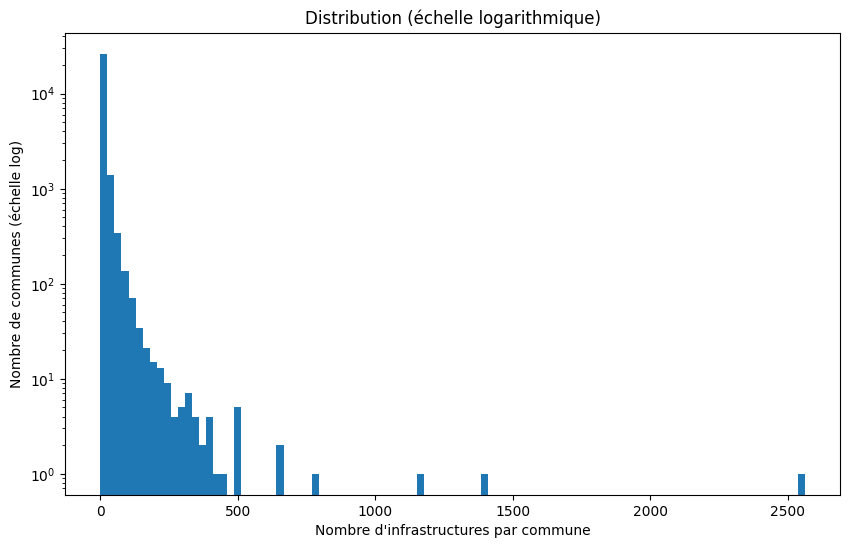

In [36]:
plt.figure(figsize=(10,6))
plt.hist(infra_par_commune["Nombre d'infrastructures par commune"], bins=100)
plt.yscale("log")
plt.xlabel("Nombre d'infrastructures par commune")
plt.ylabel("Nombre de communes (échelle log)")
plt.title("Distribution (échelle logarithmique)")
plt.show()




Le graphique obtenu ressemble la densité d'une loi exponentielle: Toutes les valeurs sont positives mais la décroissance est très forte avec juste quelques extrêmes.

In [37]:
infra_par_densite = (
    df_final.copy().groupby("Densite Catégorie")
            .size()
            .reset_index(name="Nombre d'infrastructures")
)
infra_par_densite = infra_par_densite.sort_values("Nombre d'infrastructures", ascending=False)
infra_par_densite

,Densite Catégorie,Nombre d'infrastructures
5,Rural à habitat dispersé,72774
0,Bourgs ruraux,61893
3,Grands centres urbains,53468
2,Centres urbains intermédiaires,29795
1,Ceintures urbaines,26381
4,Petites villes,20152
6,Rural à habitat très dispersé,16571


Selon la classification de l’INSEE, les communes rurales concentrent le plus grand nombre d’infrastructures sportives en valeur absolue, notamment les catégories « Rural à habitat dispersé » et « Bourgs ruraux ». Ce résultat s’explique principalement par le fait que les communes rurales représentent la grande majorité des communes françaises. Les grands centres urbains totalisent également beaucoup d’équipements, mais restent derrière car ils sont moins nombreux. Ainsi, cette répartition reflète surtout le nombre de communes par catégorie, davantage que leur niveau réel d’équipement moyen.

In [56]:
def tab_barplot(df, titre):
    """
    Affiche un graphique et un tableau côte à côte à partir d'un DataFrame à 2 colonnes
    
    Paramètre
    ----------
    df : DataFrame
        DataFrame à deux colonnes
        
    titre : str
        Titre de la figure
    """
    fig = plt.figure(figsize = (16, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)


    #Création du barplot
    ax1.bar(
    df[df.columns[0]], 
    df[df.columns[1]]
    )
    ax1.set_xlabel(df.columns[0])
    ax1.set_ylabel(df.columns[1])



    #Création du tableau
    ax2.axis('off')

    table = ax2.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center',
        colWidths=[0.4, 0.6]
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2) 

    fig.suptitle(titre)

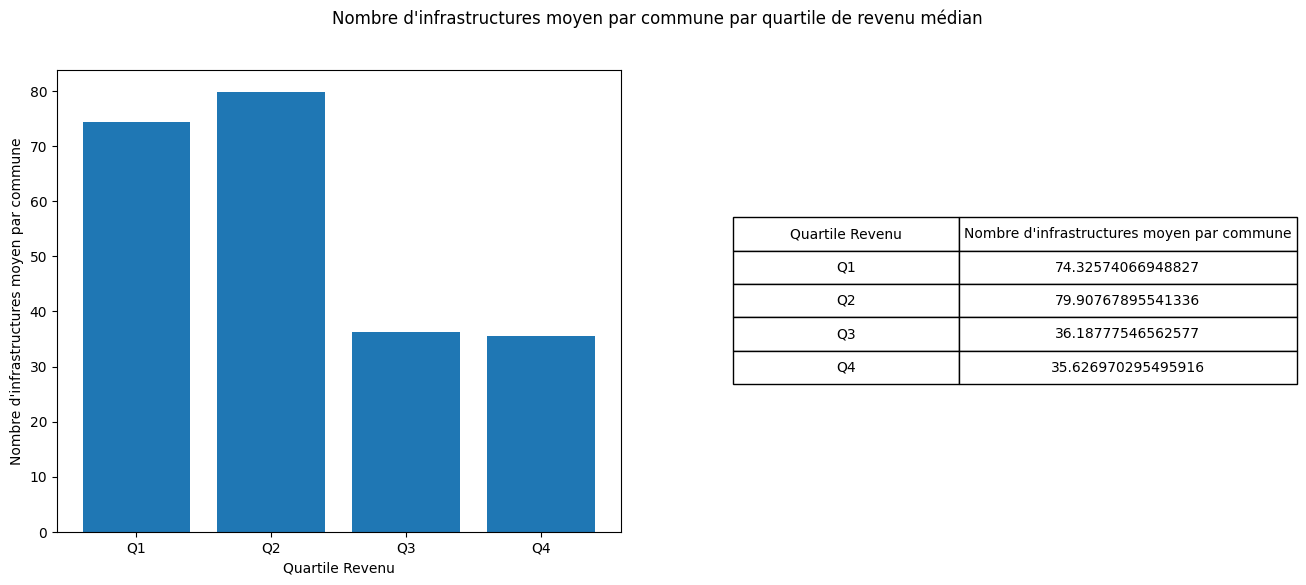

In [69]:
df_med = infra_par_commune.merge(
    df_final.copy()[["Commune nom", "MED21"]],
    on= "Commune nom",
    how="left"
)


df_med["Quartile Revenu"] = pd.qcut(
    df_med["MED21"],
    q=4,
    labels=["Q1", "Q2", "Q3", "Q4"]
)

infra_par_quartile = (
    df_med.groupby("Quartile Revenu", observed = True)["Nombre d'infrastructures par commune"]
            .mean()
            .reset_index()
)

infra_par_quartile.columns = ["Quartile Revenu", "Nombre d'infrastructures moyen par commune"]

tab_barplot(infra_par_quartile, "Nombre d'infrastructures moyen par commune par quartile de revenu médian")

D’après la distribution en quartiles du revenu médian des communes, on observe une relation contrastée entre niveau de vie et nombre d’infrastructures sportives. Les communes situées dans les quartiles Q1 et Q2 - les territoires les plus modestes - disposent en moyenne du plus grand nombre d’équipements, autour de 80 à 90 infrastructures par commune. À l’inverse, les communes appartenant aux quartiles Q3 et surtout Q4 (les plus aisées) présentent des moyennes nettement plus faibles, autour de 40 infrastructures. Cette répartition suggère que les territoires moins favorisés accueillent proportionnellement davantage d’infrastructures sportives que les plus riches, sans doute en raison de leur poids démographique ou de logiques d’aménagement spécifiques.

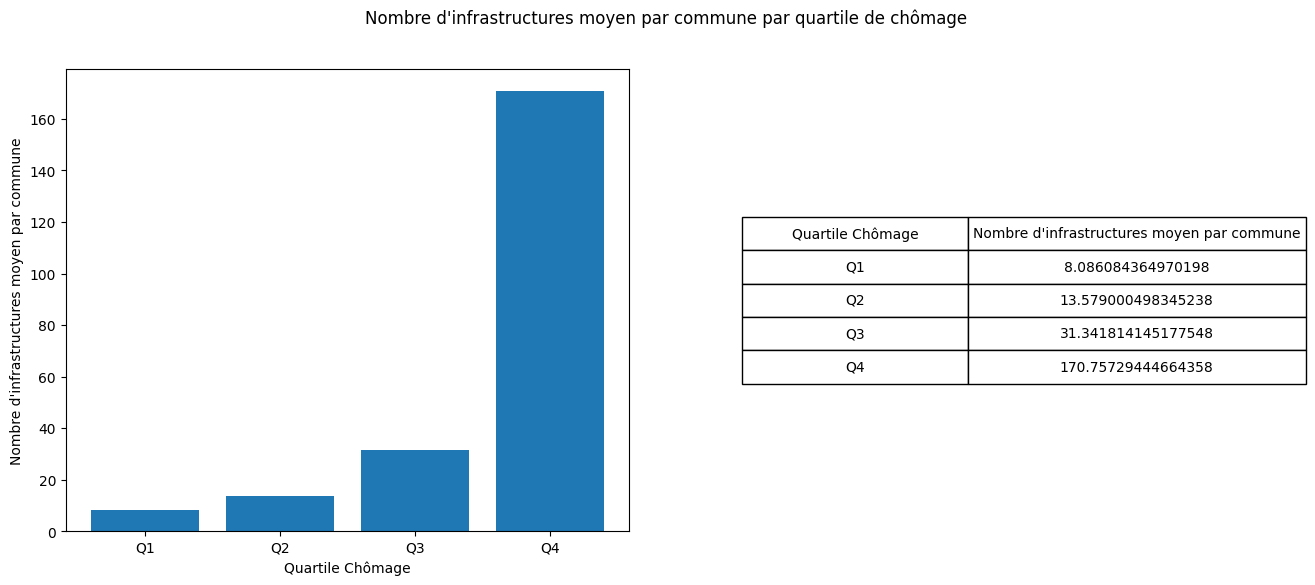

In [70]:
df_chom = infra_par_commune.merge(
    df_final.copy()[["Commune nom", "P22_CHOM1564"]],
    on= "Commune nom",
    how="left"
)


df_chom["Quartile Chômage"] = pd.qcut(
    df_chom["P22_CHOM1564"],
    q=4,
    labels=["Q1", "Q2", "Q3", "Q4"]
)

infra_par_quartile_chom = (
    df_chom.groupby("Quartile Chômage", observed = True)["Nombre d'infrastructures par commune"]
            .mean()
            .reset_index()
)

infra_par_quartile_chom.columns = ["Quartile Chômage", "Nombre d'infrastructures moyen par commune"]
tab_barplot(infra_par_quartile_chom, "Nombre d'infrastructures moyen par commune par quartile de chômage")

L’analyse par quartiles du taux de chômage montre une relation positive à celle observée avec le revenu médian. Ici, les communes les plus touchées par le chômage (quartile Q4) concentrent en moyenne beaucoup plus d’infrastructures sportives, près de 170 par commune, contre seulement 9 à 15 dans les quartiles les plus faibles (Q1–Q2). L’étude du revenu médian révélait de la même manière que les communes les plus aisées étaient plutôt moins dotées en infrastructures. Ces résultats suggèrent qu’une partie importante de l’offre sportive se situe dans des territoires plus fragiles socio-économiquement, où le niveau de chômage est élevé et les revenus plus faibles.

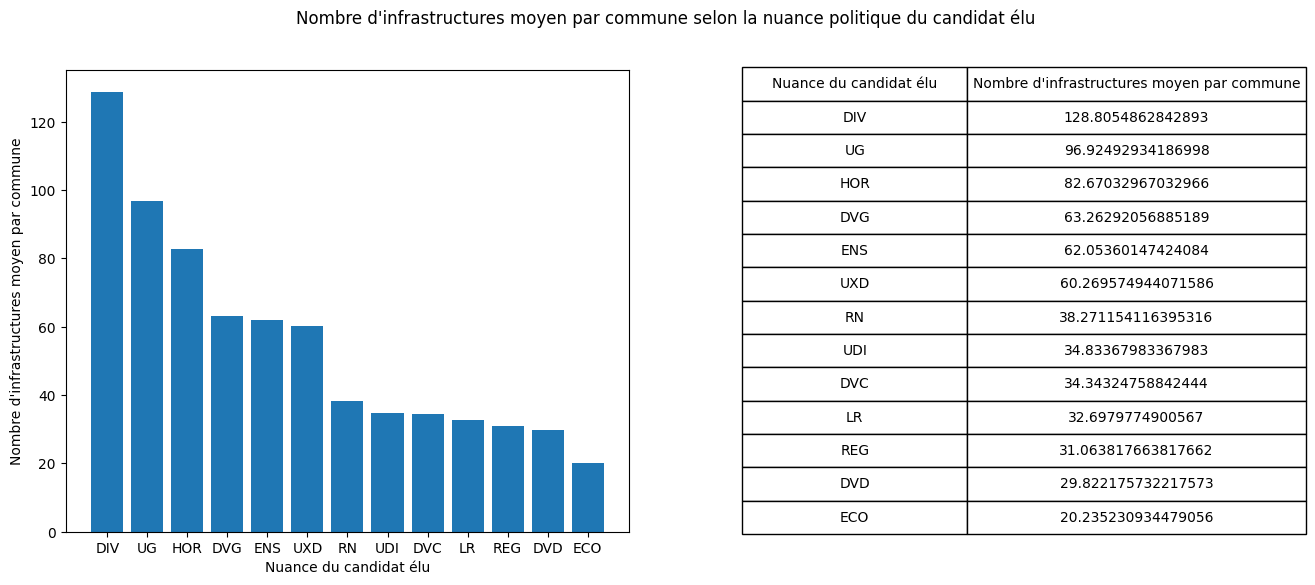

In [71]:
df_pol = infra_par_commune.merge(
    df_final.copy()[["Commune INSEE", "Nuance candidat élu"]],
    on= "Commune INSEE",
    how="left"
)


infra_par_pol= (
    df_pol.groupby("Nuance candidat élu", observed = True)["Nombre d'infrastructures par commune"]
            .mean()
            .reset_index()
)

infra_par_pol.columns = ["Nuance du candidat élu", "Nombre d'infrastructures moyen par commune"]
infra_par_pol = infra_par_pol.sort_values("Nombre d'infrastructures moyen par commune", ascending=False)

tab_barplot(infra_par_pol, "Nombre d'infrastructures moyen par commune selon la nuance politique du candidat élu")

La comparaison du nombre moyen d’infrastructures sportives selon la nuance du candidat élu en 2024 montre des écarts importants entre territoires. Les communes ayant élu un candidat classé DIV, UG ou HOR apparaissent en moyenne nettement plus dotées en équipements que celles administrées par des élus LR, REG, DVD ou ECO. Toutefois, cette lecture doit être fortement nuancée : l’élection de 2024 n’a eu quasiment aucun impact sur la présence d’infrastructures sportives, puisque celles-ci résultent d’investissements réalisés sur de longues périodes. Les différences observées reflètent donc avant tout les caractéristiques socio-économiques des territoires où ces nuances politiques sont dominantes, plutôt qu’un effet direct de l’orientation politique des élus élus en 2024.

On va maintenant faire la partie modélisation

In [80]:
#On transforme notre base de données pour faire des régressions

infra_count = df_final.groupby('Commune INSEE').size().reset_index(name='Nb_infrastructures')

autres_vars = df_final.groupby('Commune INSEE').first().reset_index()

df_commune = autres_vars.merge(infra_count, on='Commune INSEE', how='left')

df_commune.head(6)


,Commune INSEE,Code Postal,Commune nom,Département Code,Densite Catégorie,Type d'équipement sportif,Longitude,Latitude,P22_POP,P22_MEN,MED21,TP6021,P22_CHOM1564,Nuance candidat élu,Nb_infrastructures
0,01001,1400,L'Abergement-Clémenciat,1,Rural à habitat dispersé,Terrain de boules,4.920944,46.152772,859.0,354.000000,25820,s,28.000000,RN,6
1,01002,1640,L'Abergement-de-Varey,1,Rural à habitat dispersé,Espace de pratique spéléologique,5.425750,46.005410,273.0,121.000000,24480,s,2.000000,UXD,1
2,01004,1500,Ambérieu-en-Bugey,1,Centres urbains intermédiaires,Espace de pratique spéléologique,5.357770,45.958050,15554.0,7107.012476,21660,"17,0",1005.744641,UXD,53
3,01005,1330,Ambérieux-en-Dombes,1,Bourgs ruraux,Terrain de boules,4.903600,45.990600,1917.0,814.669985,24610,s,63.323397,RN,12
4,01006,1300,Ambléon,1,Rural à habitat dispersé,Espace de pratique spéléologique,5.601380,45.749440,114.0,57.000000,24210,s,5.000000,ENS,1
5,01007,1500,Ambronay,1,Rural à habitat dispersé,Espace de pratique spéléologique,5.361111,46.006389,2828.0,1207.205453,24860,s,105.671492,UXD,15


In [86]:
#On renomme les variables pour ne pas avoir d'erreurs avec statsmodels (accents et espaces)
df_commune = df_commune.rename(columns={
    "Nuance candidat élu": "Nuance_candidat",
    "Densite Catégorie": "Densite"
})

In [89]:
#Determinants du nombre d'infrastructures
model = smf.ols('Nb_infrastructures ~ P22_POP + MED21 + C(Nuance_candidat) + C(Densite)', data = df_commune.dropna()).fit(cov_type='HC3') #Robuste à l'hétéroscédasticité


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     Nb_infrastructures   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     524.2
Date:                Sun, 30 Nov 2025   Prob (F-statistic):               0.00
Time:                        12:17:28   Log-Likelihood:                -90691.
No. Observations:               24110   AIC:                         1.814e+05
Df Residuals:                   24089   BIC:                         1.816e+05
Df Model:                          20                                         
Covariance Type:                  HC3                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

Régression à venir pour mettre en exergue le rôle évident joué par le nombre d'habitants 

In [77]:
model = smf.ols('Nb_infrastructures ~ P22_POP', data = df_commune).fit(cov_type='HC3') #Robuste à l'hétéroscédasticité


print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     Nb_infrastructures   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     302.6
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           2.00e-67
Time:                        11:05:13   Log-Likelihood:            -1.0877e+05
No. Observations:               28262   AIC:                         2.175e+05
Df Residuals:                   28260   BIC:                         2.176e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2593      0.235     22.359      0.0

In [ ]:
#Commenter gros R^2 et significativité stats des coeffs

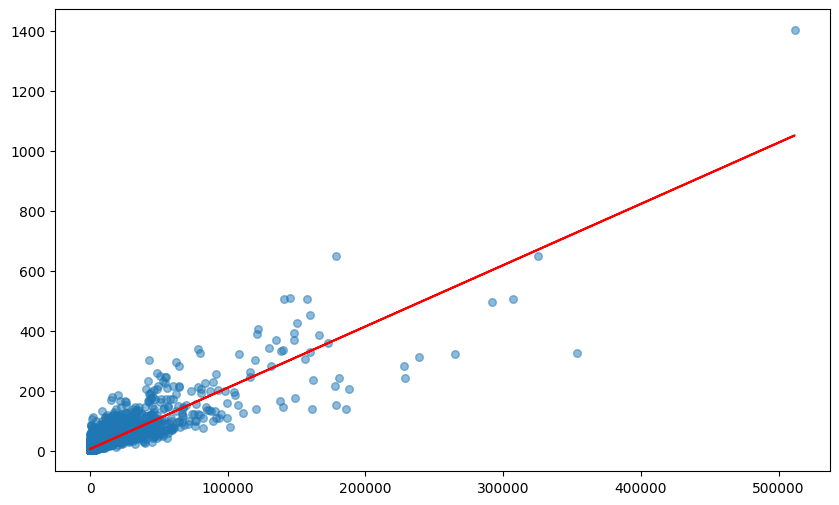

In [79]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(1, 1, 1)

# Nuage de points
ax.scatter(df_commune['P22_POP'], df_commune['Nb_infrastructures'], 
           alpha=0.5, s=30, label='Observations')
ax.plot(df_commune['P22_POP'].dropna(), model.predict(), color = "Red", label = "Droite de régression")


Cela nous incite à créer une nouvelle variable dans notre base de données : nombre d'infrastructures pour 10 000 habitants

In [91]:
df_commune["infra_10k"] = (df_commune["Nb_infrastructures"] / df_commune["P22_POP"]) * 10000
df_commune.head(6)

,Commune INSEE,Code Postal,Commune nom,Département Code,Densite,Type d'équipement sportif,Longitude,Latitude,P22_POP,P22_MEN,MED21,TP6021,P22_CHOM1564,Nuance_candidat,Nb_infrastructures,infra_10k
0,01001,1400,L'Abergement-Clémenciat,1,Rural à habitat dispersé,Terrain de boules,4.920944,46.152772,859.0,354.000000,25820,s,28.000000,RN,6,69.848661
1,01002,1640,L'Abergement-de-Varey,1,Rural à habitat dispersé,Espace de pratique spéléologique,5.425750,46.005410,273.0,121.000000,24480,s,2.000000,UXD,1,36.630037
2,01004,1500,Ambérieu-en-Bugey,1,Centres urbains intermédiaires,Espace de pratique spéléologique,5.357770,45.958050,15554.0,7107.012476,21660,"17,0",1005.744641,UXD,53,34.074836
3,01005,1330,Ambérieux-en-Dombes,1,Bourgs ruraux,Terrain de boules,4.903600,45.990600,1917.0,814.669985,24610,s,63.323397,RN,12,62.597809
4,01006,1300,Ambléon,1,Rural à habitat dispersé,Espace de pratique spéléologique,5.601380,45.749440,114.0,57.000000,24210,s,5.000000,ENS,1,87.719298
5,01007,1500,Ambronay,1,Rural à habitat dispersé,Espace de pratique spéléologique,5.361111,46.006389,2828.0,1207.205453,24860,s,105.671492,UXD,15,53.041018


In [93]:
model = smf.ols('infra_10k ~ MED21 + C(Nuance_candidat) + C(Densite)', data = df_commune.dropna()).fit(cov_type='HC3') #Robuste à l'hétéroscédasticité


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              infra_10k   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     251.3
Date:                Sun, 30 Nov 2025   Prob (F-statistic):               0.00
Time:                        12:28:22   Log-Likelihood:            -1.4518e+05
No. Observations:               24110   AIC:                         2.904e+05
Df Residuals:                   24090   BIC:                         2.906e+05
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [ ]:
#C'est quoi le problème avec le R^2 ?

In [110]:
df_cluster = df_commune.copy()
df_cluster = df_cluster.dropna()

df_cluster = pd.get_dummies(df_cluster, 
                            columns=["Densite"], 
                            drop_first=False)

vars_clustering = [col for col in df_cluster.columns 
                   if col.startswith("Densite_")] + [
    "Nb_infrastructures", "MED21", "P22_POP"
]

X = df_cluster[vars_clustering]


# standardisation (important)
X_scaled = StandardScaler().fit_transform(X)


# clustering en 4 groupes
kmeans = KMeans(n_clusters=4, random_state=42)
df_cluster["cluster"] = kmeans.fit_predict(X_scaled)

df_cluster.head(6)

,Commune INSEE,Code Postal,Commune nom,Département Code,Type d'équipement sportif,Longitude,Latitude,P22_POP,P22_MEN,MED21,...,Nb_infrastructures,infra_10k,Densite_Bourgs ruraux,Densite_Ceintures urbaines,Densite_Centres urbains intermédiaires,Densite_Grands centres urbains,Densite_Petites villes,Densite_Rural à habitat dispersé,Densite_Rural à habitat très dispersé,cluster
0,01001,1400,L'Abergement-Clémenciat,1,Terrain de boules,4.920944,46.152772,859.0,354.000000,25820,...,6,69.848661,False,False,False,False,False,True,False,1
1,01002,1640,L'Abergement-de-Varey,1,Espace de pratique spéléologique,5.425750,46.005410,273.0,121.000000,24480,...,1,36.630037,False,False,False,False,False,True,False,1
2,01004,1500,Ambérieu-en-Bugey,1,Espace de pratique spéléologique,5.357770,45.958050,15554.0,7107.012476,21660,...,53,34.074836,False,False,True,False,False,False,False,3
3,01005,1330,Ambérieux-en-Dombes,1,Terrain de boules,4.903600,45.990600,1917.0,814.669985,24610,...,12,62.597809,True,False,False,False,False,False,False,0
4,01006,1300,Ambléon,1,Espace de pratique spéléologique,5.601380,45.749440,114.0,57.000000,24210,...,1,87.719298,False,False,False,False,False,True,False,1
5,01007,1500,Ambronay,1,Espace de pratique spéléologique,5.361111,46.006389,2828.0,1207.205453,24860,...,15,53.041018,False,False,False,False,False,True,False,1


In [117]:
# Préparation des données
df_lasso = df_commune.copy()

# Variables numériques
vars_numeriques = ['P22_POP', 'MED21', 'P22_CHOM1564']

# Variables catégorielles
vars_categorielles = ['Nuance_candidat', 'Densite']

# Sélection des variables
colonnes = vars_numeriques + vars_categorielles + ['Nb_infrastructures']
df_lasso = df_lasso[colonnes].dropna()

#Création des variables binaires (drop_first=True évite la colinéarité)
df_avec_dummies = pd.get_dummies(
    df_lasso,
    columns=vars_categorielles,  
    drop_first=True,
    prefix=['Nuance', 'Den']
)

#Séparation pour standardiser X
y = df_avec_dummies['Nb_infrastructures']
X = df_avec_dummies.drop('Nb_infrastructures', axis=1)

#Standardisation X
X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

lasso_cv = LassoCV(
    cv=10,              # 10-fold cross-validation
    random_state=42,
    max_iter=10000,
    n_alphas=100        # Teste 100 valeurs d'alpha différentes
)

# Entraînement
lasso_cv.fit(X_scaled, y)

coefficients = pd.DataFrame({
    'Variable': X.columns,
    'Coefficient': lasso_cv.coef_,
    'Coefficient_abs': np.abs(lasso_cv.coef_)
}).sort_values('Coefficient_abs', ascending=False)

print("Tous les coefficients (triés par importance) :")
print(coefficients.to_string(index=False))


/opt/python/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


Tous les coefficients (triés par importance) :
                          Variable  Coefficient  Coefficient_abs
                           P22_POP    17.977005        17.977005
Den_Centres urbains intermédiaires     2.155129         2.155129
      Den_Rural à habitat dispersé    -2.018792         2.018792
 Den_Rural à habitat très dispersé    -1.935442         1.935442
                      P22_CHOM1564     1.543089         1.543089
                             MED21    -1.056354         1.056354
                Den_Petites villes     0.963737         0.963737
                         Nuance_RN    -0.337715         0.337715
        Den_Grands centres urbains    -0.256481         0.256481
                        Nuance_ENS     0.223467         0.223467
                        Nuance_DVG     0.100736         0.100736
                         Nuance_UG     0.097013         0.097013
                        Nuance_UXD    -0.012482         0.012482
                        Nuance_DVD    -0.00

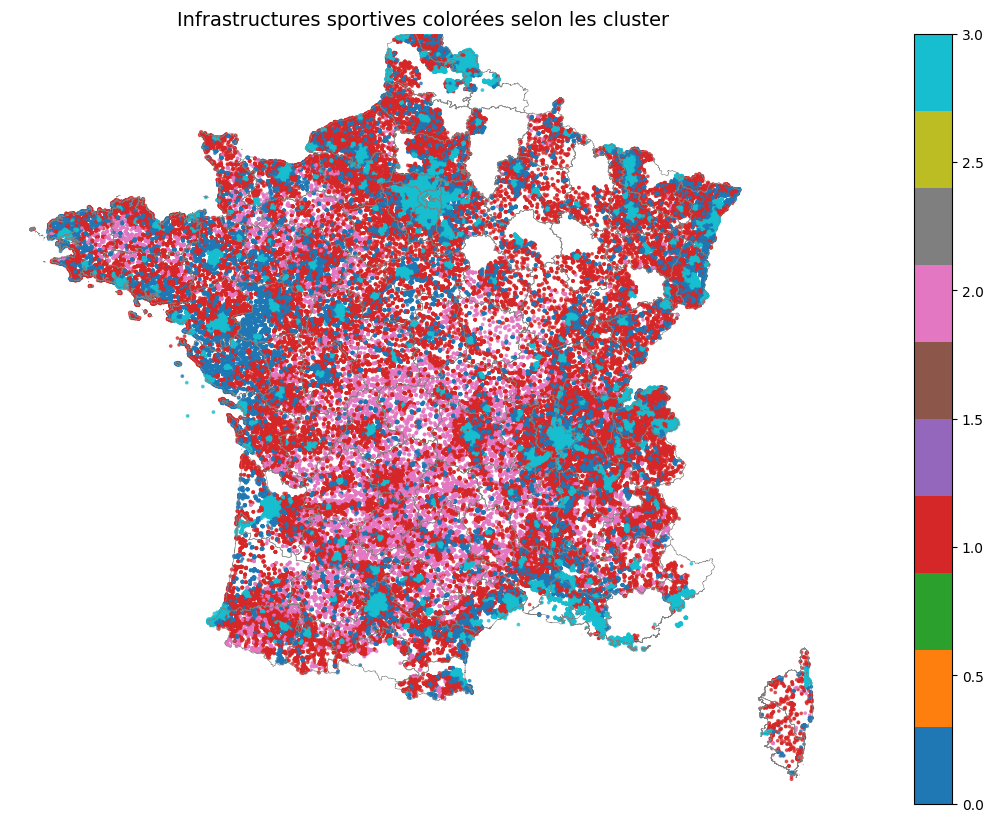

In [111]:
df_final_cluster = df_final.merge(
    df_cluster[["Commune INSEE", "cluster"]],
    on="Commune INSEE",
    how="left"
)

gdf_pts = gpd.GeoDataFrame(
    df_final_cluster,
    geometry=gpd.points_from_xy(df_final_cluster["Longitude"], df_final_cluster["Latitude"]),
    crs="EPSG:4326"
)


fig, ax = plt.subplots(figsize=(20, 10))
gdf.boundary.plot(ax=ax, linewidth=0.4, color="gray")
gdf_pts.plot(ax=ax, markersize=3, alpha=0.7, column="cluster", cmap = "tab10", legend = True)
ax.set_xlim(-5.5, 10) 
ax.set_ylim(41, 51)
ax.set_title("Infrastructures sportives colorées selon les cluster", fontsize=14)
ax.set_axis_off()
plt.savefig('docs/carte_clusters.png', dpi=300, bbox_inches='tight')

In [ ]:
#Je sais pas pourquoi il manque des points (peut être à cause de dropna dans le clustering?)
#Essayer de commenter quand même 

In [112]:
!nb-clean clean Projet.ipynb

In [113]:
!ls -lh Projet.ipynb

-rw-r--r-- 1 onyxia users 38K Nov 29 22:29 Projet.ipynb
